In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.mlab import griddata

In [2]:
import tensorflow.contrib.distributions as ds

In [3]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [4]:
num_samples = 100000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)

In [5]:
import tensorflow as tf

In [6]:
import tensorflow.contrib.layers as layers

In [7]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [8]:
# batch size for evaluation of mutual entropy
MINE_batch_size = num_samples

# batch size for the training of the encoder / classifier pair
batch_size = 200

bottleneck_size = 2

In [9]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
nuisances_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisances_in')
labels_in = tf.placeholder(tf.int32, [None, ], name = 'labels_in')

In [10]:
def classifier(classifier_input):
    with tf.variable_scope("classifier"):
        lay = layers.relu(classifier_input, 50)
        lay = layers.relu(lay, 50)
        lay = layers.relu(lay, 20)
        lay = layers.relu(lay, 2)
        outputs = layers.softmax(lay)
        
        these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "classifier")

    return outputs, these_vars

In [11]:
def EM_network(data_P, data_Q, name):
    with tf.variable_scope(name):  
        data_combined = tf.concat([data_P, data_Q], axis = 0)
        
        lay = layers.relu(data_combined, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [12]:
def EM_loss(EM_output, name):
    with tf.variable_scope(name):
        batch_size_dyn = tf.cast(tf.math.divide(tf.shape(EM_output)[0], 2), tf.int32)
        
        T_P = EM_output[:batch_size_dyn,:]
        T_Q = EM_output[batch_size_dyn:,:]
        
        EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
        
        EM_loss = EM_loss[0]
        
    return EM_loss

In [13]:
with tf.variable_scope('model_params'):
    low = tf.Variable(0.6, 'low')
    high = tf.Variable(0.05, 'high')

model_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'model_params')

In [14]:
classifier_output, classifier_vars = classifier(data_in)

In [15]:
classifier_output_expanded = tf.expand_dims(classifier_output[:,0], axis = 1)

In [16]:
bkg_indices = tf.where(tf.math.less(labels_in, 1))

In [17]:
classifier_bkg_input_samples = tf.gather_nd(data_in, bkg_indices)

In [18]:
classifier_bkg_samples = tf.gather_nd(classifier_output_expanded, bkg_indices)

In [19]:
model = ds.Normal(loc = low, scale = high)

In [20]:
#batch_size_dyn = tf.cast(tf.shape(classifier_bkg_samples)[0], tf.int32)
samples_model = model.sample((1000, 1))

In [21]:
EM_output, EM_vars = EM_network(classifier_bkg_samples, samples_model, name = 'EM')

In [22]:
EM_lossval = EM_loss(EM_output, 'EM_loss')

In [23]:
clipval = 0.2
clip_EM_network = [var.assign(tf.clip_by_value(var, -clipval, clipval)) for var in EM_vars]

In [24]:
labels_one_hot = tf.one_hot(labels_in, depth = 2)

In [25]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = classifier_output)

In [26]:
EM_regularized_loss = classification_loss + EM_lossval

In [50]:
train_classifier = tf.train.AdamOptimizer(learning_rate = 0.005, beta1 = 0.9, beta2 = 0.999).minimize(classification_loss, var_list = classifier_vars)

In [51]:
train_regularized_classifier = tf.train.AdamOptimizer(learning_rate = 0.005, beta1 = 0.9, beta2 = 0.999).minimize(EM_regularized_loss, var_list = classifier_vars)

/home/philipp/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [52]:
train_EM = tf.train.AdamOptimizer(learning_rate = 0.05, beta1 = 0.3, beta2 = 0.5).minimize(-EM_lossval, var_list = EM_vars)

In [53]:
# combined training
classification_loss_evolution = []
MI_evolution = []
number_batches = 200
MINE_batches = 300

In [54]:
number_epochs = 10

In [61]:
sess.run(tf.global_variables_initializer())

In [62]:
train_bkg = labels_train == 0
bkg_data_train = data_train[train_bkg]
bkg_labels_train = labels_train[train_bkg]

In [63]:
train_sig = labels_train == 1
sig_data_train = data_train[train_sig]
sig_labels_train = labels_train[train_sig]

In [64]:
init_EM = tf.variables_initializer(var_list = EM_vars)

In [65]:
sess.run(init_EM)

In [66]:
# pre-train EM
for batch in range(5000):
    inds = np.random.choice(len(bkg_data_train), 1000)
    bkg_batch_data = bkg_data_train[inds]
    bkg_batch_labels = bkg_labels_train[inds]
    
    sess.run([train_EM, clip_EM_network], feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})
    
    if not batch % 200:
        cur_EM = sess.run(EM_lossval, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})
        print("EM = {}".format(cur_EM))

EM = 0.0017126165330410004
EM = 0.024080075323581696
EM = 0.026623964309692383
EM = 0.025225073099136353
EM = 0.041665852069854736
EM = 0.04164966568350792
EM = 0.05274662375450134
EM = 0.02929726243019104
EM = 0.0282646082341671
EM = 0.029039578512310982
EM = 0.033907439559698105
EM = 0.03173074871301651
EM = 0.04178471863269806
EM = 0.028302541002631187
EM = 0.06202367693185806
EM = 0.03556334227323532
EM = 0.0458366721868515
EM = 0.030056752264499664
EM = 0.05328720808029175
EM = 0.05483226478099823
EM = 0.037202637642621994
EM = 0.034711770713329315
EM = 0.0426325798034668
EM = 0.057726114988327026
EM = 0.029642056673765182


In [67]:
cls_bkg = sess.run(classifier_bkg_samples, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})

In [68]:
target_bkg = sess.run(samples_model, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})

In [69]:
np.savetxt("cls_bkg.txt", cls_bkg)
np.savetxt("target_bkg.txt", target_bkg)

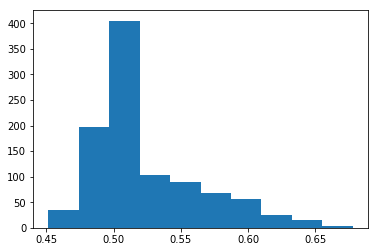

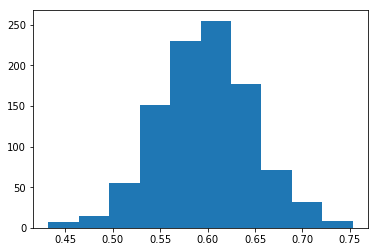

In [70]:
plt.hist(cls_bkg)
plt.show()
plt.hist(target_bkg)
plt.show()

In [71]:
cur_EM = sess.run(EM_lossval, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})
print("EM after pre-training = {}".format(cur_EM))

EM after pre-training = 0.032878339290618896


In [78]:
for epoch in range(1):
    print("epoch {}".format(epoch))
    
    for batch in range(10):
        
        # update EM
        sess.run(init_EM)
        for i in range(5000):
            inds = np.random.choice(len(bkg_data_train), 1000)
            bkg_batch_data = bkg_data_train[inds]
            bkg_batch_labels = bkg_labels_train[inds]
    
            sess.run([train_EM, clip_EM_network], feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})
  
        # train regularized classifier on sig + bkg
        inds_bkg = np.random.choice(len(bkg_data_train), 1000)
        bkg_batch_data = bkg_data_train[inds_bkg]
        bkg_batch_labels = bkg_labels_train[inds_bkg]

        inds_sig = np.random.choice(len(sig_data_train), 1000)
        sig_batch_data = sig_data_train[inds_sig]
        sig_batch_labels = sig_labels_train[inds_sig]

        data_batch = np.concatenate([sig_batch_data, bkg_batch_data])
        labels_batch = np.concatenate([sig_batch_labels, bkg_batch_labels])

        #data_batch = bkg_batch_data
        #labels_batch = bkg_batch_labels
        
        sess.run(train_regularized_classifier, feed_dict = {data_in: data_batch, labels_in: labels_batch})
                
        if not batch % 1:
            cur_EM = sess.run(EM_lossval, feed_dict = {data_in: data_batch, labels_in: labels_batch})
            class_loss = sess.run(classification_loss, feed_dict = {data_in: data_batch, labels_in: labels_batch})
            tot_loss = sess.run(EM_regularized_loss, feed_dict = {data_in: data_batch, labels_in: labels_batch})
            print("class_loss = {}, EM = {}, tot = {}".format(class_loss, cur_EM, tot_loss))

epoch 0
class_loss = 0.6481388211250305, EM = 0.00652921199798584, tot = 0.655367910861969
class_loss = 0.6464396715164185, EM = 0.0, tot = 0.6464396715164185
class_loss = 0.638858437538147, EM = 0.0062043070793151855, tot = 0.645016610622406
class_loss = 0.6383868455886841, EM = 0.04084300994873047, tot = 0.6749669909477234
class_loss = 0.6337181329727173, EM = 0.0, tot = 0.6337181329727173
class_loss = 0.6341246366500854, EM = 0.0, tot = 0.6341246366500854
class_loss = 0.6280760765075684, EM = -0.0008628368377685547, tot = 0.6280231475830078
class_loss = 0.6330222487449646, EM = 0.0, tot = 0.6330222487449646
class_loss = 0.6262801289558411, EM = 0.012843474745750427, tot = 0.6400458812713623
class_loss = 0.6301877498626709, EM = 0.041705042123794556, tot = 0.6734485626220703


In [79]:
data_test = np.loadtxt("data_test.txt")
nuisances_test = np.loadtxt("nuisances_test.txt")
labels_test = np.loadtxt("labels_test.txt")

In [80]:
sig = data_test[labels_test == 1]
bkg = data_test[labels_test == 0]

In [81]:
pred_sig = sess.run(classifier_output, feed_dict = {data_in: sig})
pred_bkg = sess.run(classifier_output, feed_dict = {data_in: bkg})

In [82]:
target = [sess.run(samples_model) for i in range(10)]

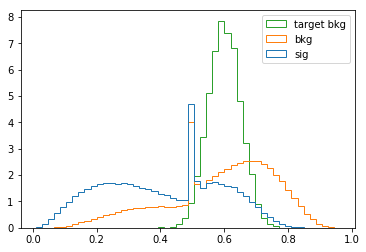

In [83]:
plt.hist([pred_sig[:,0], pred_bkg[:,0], target], label = ['sig', 'bkg', 'target bkg'], histtype = 'step', density = True, stacked = False, fill = False, bins = 50)
plt.legend()
plt.show()

In [ ]:
# plot ROC curves
from sklearn import metrics

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred[:,1])

In [ ]:
metrics.roc_auc_score(labels_test, pred[:,1])

In [ ]:
# and load back the values of the (exact) ML estimator evaluated on them
LL_pred = np.loadtxt("LL_evaluated.csv")

In [ ]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

In [ ]:
metrics.roc_auc_score(labels_test, LL_pred)

In [ ]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label = 'shaped classifier', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()